In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

from openquake.hazardlib.source import AreaSource
from openquake.hazardlib.mfd import TruncatedGRMFD
from openquake.hazardlib.scalerel import WC1994
from openquake.hazardlib.geo import Point, NodalPlane, Polygon
from openquake.hazardlib.pmf import PMF
from openquake.hazardlib.tom import PoissonTOM
from openquake.hazardlib.calc.hazard_curve import calc_hazard_curves
from openquake.hazardlib.calc import disaggregation, mag_dist_pmf
from openquake.hazardlib.site import Site, SiteCollection
from openquake.hazardlib.imt import PGA
from openquake.hazardlib.gsim.campbell_bozorgnia_2008 import CampbellBozorgnia2008

import numpy
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# define area source of circular shape of radius 200 km
src = AreaSource(
    source_id='1',
    name='area',
    tectonic_region_type='Active Shallow Crust',
    mfd=TruncatedGRMFD(min_mag=5., max_mag=6.5, bin_width=0.2, a_val=4.45, b_val=1.),
    rupture_mesh_spacing=2.,
    magnitude_scaling_relationship=WC1994(),
    rupture_aspect_ratio=1.,
    temporal_occurrence_model=PoissonTOM(50.),
    upper_seismogenic_depth=2.,
    lower_seismogenic_depth=12.,
    nodal_plane_distribution=PMF([(1, NodalPlane(strike=0., dip=90, rake=0.))]),
    hypocenter_distribution=PMF([(1, 7.)]),
    polygon=Point(0., 0.).to_polygon(200.),
    area_discretization=10.
)


In [4]:

# first compute hazard curve
imls = [0.005, 0.007, 0.0098, 0.0137, 0.0192, 0.0269, 0.0376, 0.0527, 0.0738, 0.103, 0.145,
        0.203, 0.284, 0.397, 0.556, 0.778, 1.09, 1.52, 2.13]
site = Site(location=Point(0., 0.), vs30=760., vs30measured=True, z1pt0=40., z2pt5=1.)

curves = calc_hazard_curves(
    groups=[src],
    srcfilter=SiteCollection([site]),
    imtls={'PGA': imls},
    gsim_by_trt={'Active Shallow Crust': CampbellBozorgnia2008()},
    truncation_level=None
)

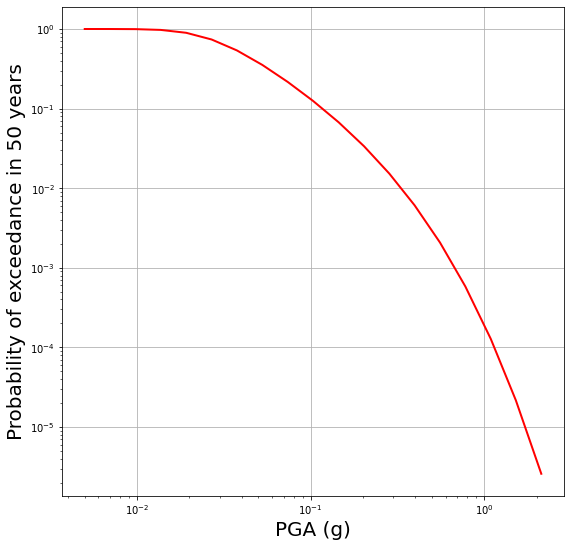

In [5]:

fig = pyplot.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
ax.plot(imls, curves['PGA'][0], '-r', linewidth=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
txt = ax.set_xlabel('PGA (g)', fontsize=20)
txt = ax.set_ylabel('Probability of exceedance in 50 years', fontsize=20)

In [13]:

# disaggregate ground motion value corresponding to 0.1 poe
poes = curves['PGA'][0]
iml = numpy.interp([0.1], poes[::-1], imls[::-1])

(mags, dists, lons, lats, eps, trts), diss_matrix = disaggregation(
    sources=[src],
    site=site,
    imt=PGA(),
    iml=iml,
    gsim_by_trt={'Active Shallow Crust': CampbellBozorgnia2008()},
    truncation_level=3,
    n_epsilons=3,
    mag_bin_width=0.5,
    dist_bin_width=20.,
    coord_bin_width=.2
)

ValueError: too many values to unpack (expected 2)

In [7]:
help(disaggregation)

Help on function disaggregation in module openquake.hazardlib.calc.disagg:

disaggregation(sources, site, imt, iml, gsim_by_trt, truncation_level, n_epsilons, mag_bin_width, dist_bin_width, coord_bin_width, source_filter=<openquake.hazardlib.calc.filters.SourceFilter object at 0x7fdcd01bff28>, **kwargs)
    Compute "Disaggregation" matrix representing conditional probability of an
    intensity mesaure type ``imt`` exceeding, at least once, an intensity
    measure level ``iml`` at a geographical location ``site``, given rupture
    scenarios classified in terms of:
    
    - rupture magnitude
    - Joyner-Boore distance from rupture surface to site
    - longitude and latitude of the surface projection of a rupture's point
      closest to ``site``
    - epsilon: number of standard deviations by which an intensity measure
      level deviates from the median value predicted by a GSIM, given the
      rupture parameters
    - rupture tectonic region type
    
    In other words, the d